# 图像生成
近年来, 图像生成领域取得了巨大的进步，特别是生成对抗网络(Gnerator Adversarial Nets, GAN)的出现，算法可以生成逼真清晰的自然图像。下面介绍生成对抗网络的有关知识：
## 生成对抗网络

对抗生成网络的核心思想来自于博弈论的二人零和博弈，基本的GAN模型在结构是由生成器（Generator）与判别器（Discriminator）组成，如图所示：
<center > ![framework.png](./framework.PNG) </center>

生成器G可以捕捉样本数据的分布，用服从某一分布(均匀分布，高斯分布等)的噪声z生成一个接近真实训练数据的样本，目的是为了生成逼近真实样本，能以假乱真。判别器D则是一个二分类器，用来判别样本来自训练数据（非生成数据）的概率，若样本来自真实的训练数据，则判别器的输出越接近1，否则输出越接近于0，从而有效区分真实样本与生成器生成的样本。随着时间的推移，生成器与判别器在不断地进行对抗，最终两个网络达到一个动态均衡：生成器生成的样本接近于真实样本的分布，此时判别器也识别不出真假样本，即对于给定样本的预测为真的概率基本接近于0.5（相当于随机猜测）。
## 训练策略
生成对抗网络的训练过程可表示如下：

$$ \min\limits_{G} \max\limits_{D} V(D,G)=\mathbb{E}_{x\sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[\log(1 - D(G(z)))] $$

从上述公式可以看出，对于生成器，需要最小化损失函数，对于判别器，需要最大化损失函数，交替优化，直至达到纳什均衡点（Nash equilibrium），所以训练过程分为两个步骤：

- D-step:

$$ J^{(D)}=-\mathbb{E}_{x\sim p_{data}}[\log D(x)] - \mathbb{E}_{z\sim p_{z}(z)}[\log (1 - D(G(z)))]$$

- G-step:

$$ J^{(G)} = \mathbb{E}_{z\sim p_{z}(z)}\log (1- D(G(z)))$$



上述过程的D-step与G-step交替执行优化，分别更新生成器与判别器的参数权重。然后，有时G-step优化过程易出现饱和现象，所以优化目标$ J^{(G)}$修改为:

$$ J^{(G)} = -\mathbb{E}_{z\sim p_{z}(z)}\log D(G(z))$$


## DCGAN之图像生成实例
卷积神经网络在有监督学习中的各项任务中都有很好的表现，但在无监督学习领域，应用却比较少。DCGAN就是讲有监督学习中的CNN和无监督学习中的GAN结合在一起，可以看成GAN扩展到CNN领域。GAN训练起来非常不稳定，DCGAN为CNN的网络结构增加一系列的限制使得训练相对稳定。下面详细实现DCGAN的具体细节：

In [1]:
import os,time,itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
def lrelu(x, th=0.2):
    return tf.maximum(th*x,x)

DCGNA的生成器网络采用CNN结构，并在输出层使用tanh激活函数，值域范围映射到[-1,1]

In [3]:
# 生成器
def generator(x, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):

        conv1 = tf.layers.conv2d_transpose(x, 1024, [4, 4], strides=(1, 1), padding='valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training=isTrain), 0.2)


        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        
        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        
        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)


        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4, 4], strides=(2, 2), padding='same')
        o = tf.nn.tanh(conv5)

        return o


DCGAN的判别器同样使用CNN结构，并使用sigmoid激活函数，输出属于真实图片的概率，判别器收敛时候往往概率值在0.5附近，即真假难以分辨

In [4]:
# 判别器
def discriminator(x, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
       
        conv1 = tf.layers.conv2d(x, 128, [4, 4], strides=(2, 2), padding='same')
        lrelu1 = lrelu(conv1, 0.2)

        
        conv2 = tf.layers.conv2d(lrelu1, 256, [4, 4], strides=(2, 2), padding='same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

       
        conv3 = tf.layers.conv2d(lrelu2, 512, [4, 4], strides=(2, 2), padding='same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training=isTrain), 0.2)

        
        conv4 = tf.layers.conv2d(lrelu3, 1024, [4, 4], strides=(2, 2), padding='same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training=isTrain), 0.2)

        
        conv5 = tf.layers.conv2d(lrelu4, 1, [4, 4], strides=(1, 1), padding='valid')
        o = tf.nn.sigmoid(conv5)

        return o, conv5


此处生成固定的随机高斯噪声，用于观察GAN的训练的结果

In [5]:
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))
# 显示每个epoch的训练结果
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, isTrain: False})

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        
# 显示训练过程loss的变化曲线      
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

设置训练的相关参数

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
training start!


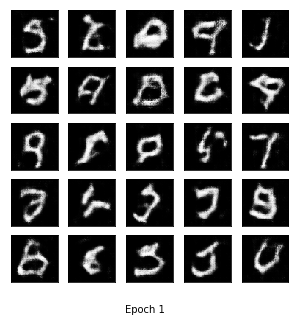

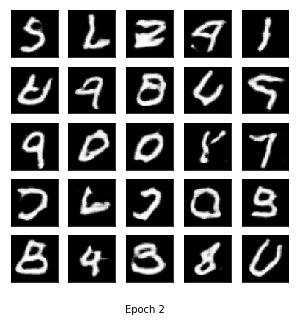

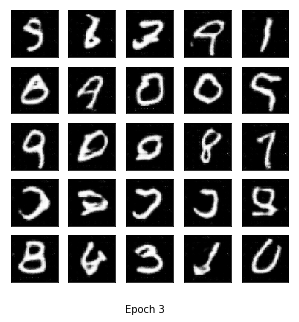

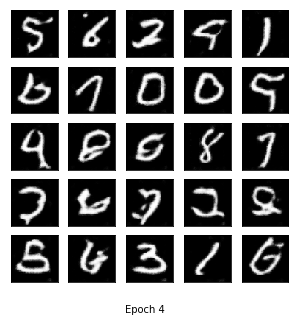

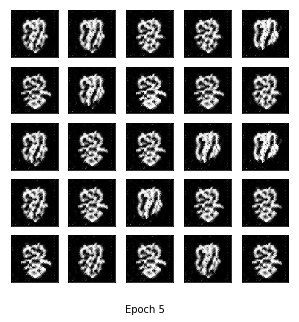

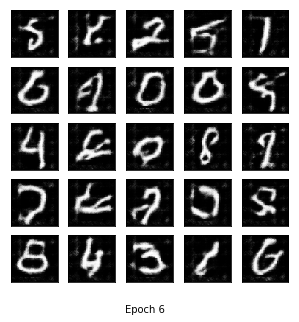

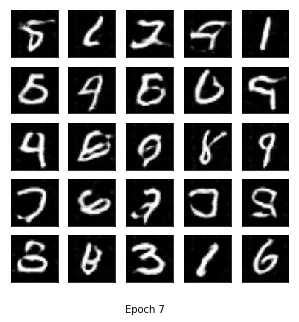

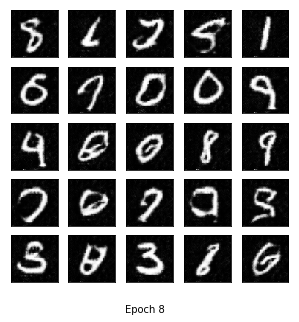

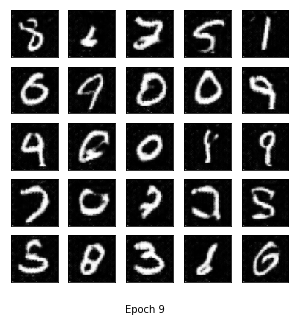

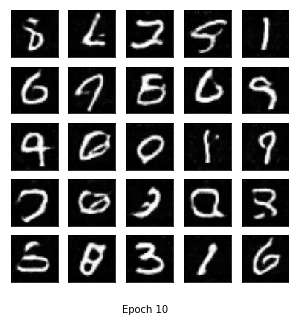

Training finish!


In [6]:
# 训练参数设置
batch_size = 100
lr = 0.0002
train_epoch = 10

# 加载mnist数据集
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])

# 设置占位符
x = tf.placeholder(tf.float32, shape=(None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
isTrain = tf.placeholder(dtype=tf.bool)

# 从随机噪声生成伪造图像
G_z = generator(z, isTrain)

# 对真实图像进行判别
D_real, D_real_logits = discriminator(x, isTrain)
# 对伪造图像进行判别
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse=True)

# 计算损失函数
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# 声明生成器与判别器的可训练变量
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# 生成器与判别器的优化器
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)

# 创建会话并初始化变量
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# 加载mnist数据并做归一化处理[-1,1]
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5  # normalization; range: -1 ~ 1

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# 训练迭代
np.random.seed(int(time.time()))
print('training start!')
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    for iter in range(mnist.train.num_examples // batch_size):
        # 更新判别器参数
        x_ = train_set[iter*batch_size:(iter+1)*batch_size]
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, isTrain: True})
        D_losses.append(loss_d_)

        # 更新生成器参数
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, isTrain: True})
        G_losses.append(loss_g_)
        
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    show_result((epoch + 1), show=True)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
print("Training finish!")

训练过程的loss变化曲线如下：

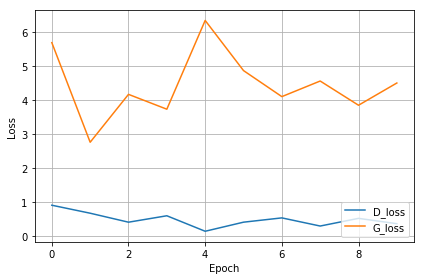

In [7]:
show_train_hist(train_hist, show=True)

理想情况下，判别器是无法分辨真实图像与伪造的图像，即判别器相当于随机猜测，值得注意的是，DCGAN的训练是不稳定的，有时会存在模式坍塌(mode collapse),即学习过程发生崩溃问题，生成器开始退化，不管随机噪声z的变化，总是生成类似的样本点，无法继续学习，克服训练不稳定以及模型坍塌的情况，可以参见WGAN。